# Main class Analysis (Microarray)

Vogliamo eseguire le analisi svolte precedentemente utilizzando solo le 4 classi principali di tumore al seno: LumA, LumB, Basal e Her2. 

Estraiamo i dati RNA-Seq relativi ai campioni:

In [1]:
import pandas as pd 
import numpy  as np

from modules import autoencoder as ae 
from modules import microarray
from modules import postprocess as post
from modules import utilities as util

Partendo dal dataset di feature geniche, associamo ogni campione al relativo sottotipo di tumore.

In [2]:
df = microarray.get_samples_with_label('CLAUDIN_SUBTYPE')
df.rename(columns={'CLAUDIN_SUBTYPE': 'SUBTYPE'}, inplace=True)

# print all the classes found 
classes  = df['SUBTYPE'].unique()
print(f"Sono presenti {len(classes)} classi.")
for subt in classes:
    print(f"> {subt}")

Sono presenti 7 classi.
> LumA
> Her2
> claudin-low
> Basal
> LumB
> Normal
> NC


## Rimozione delle classi secondarie

Rimuoviamo i dati appartenenti alle classi secondarie.

In [3]:
# define the classes to maintain 
main_classes = [
    'LumA', 
    'LumB', 
    'Basal', 
    'Her2'
]

# check the rows with a main subtype
main_class_rows = df['SUBTYPE'].isin(main_classes)

# select only those rows
df = df[main_class_rows]

# check the subtypes now 
classes  = df['SUBTYPE'].unique()
print(f"Sono presenti {len(classes)} classi.")
for subt in classes:
    print(f"> {subt}")

Sono presenti 4 classi.
> LumA
> Her2
> Basal
> LumB


## Preparazione al training

Dato che ci basiamo sulle classi principali, è corretto effettuare un partizionamento bilanciato. Utilizziamo la funzione definita nel modulo utilities a questo scopo. 

In [ ]:
# create balanced (in terms of subtypes) sets 
df_train, df_valid = util.multilabel_train_test_split(df, 'SUBTYPE', .1)
df_train, df_tests = util.multilabel_train_test_split(df_train, 'SUBTYPE', .1)

# drop the subtype label 
df_train = df_train.drop('SUBTYPE', axis=1)
df_valid = df_valid.drop('SUBTYPE', axis=1)
df_tests = df_tests.drop('SUBTYPE', axis=1)

# scale the data using rescaling method
x_train, x_tests, scaler = util.normalize_sets(df_train, df_tests)
x_valid = util.normalize_with_pretrained_scaler(scaler, df_valid)

## Creazione blind autoencoder

Anziché sfruttare i modelli precedentemente realizzati (BLA150, BLA50, BLA25), creeremo un unico autoencoder che includa degli hidden layer a 150, 50 e 25 unità. Questo ci permetterà di estrarre dataset compressi in diversi embedding space con un solo processo di training.

In [ ]:
_, ny = x_train.shape

encoder_components = [
    {'latent_space': 15000, 'activation': 'relu', 'batch_norm_output': True}, 
    {'latent_space': 7500,  'activation': 'relu', 'batch_norm_output': True}, 
    {'latent_space': 3000,  'activation': 'relu', 'batch_norm_output': True},
    {'latent_space': 1000,  'activation': 'relu', 'batch_norm_output': True},
    {'latent_space': 150,   'activation': 'relu', 'batch_norm_output': True},
    {'latent_space': 50,    'activation': 'relu', 'batch_norm_output': True},
    {'latent_space': 25,    'activation': 'relu', 'batch_norm_output': True},
]

decoder_components = [
    {'latent_space': 50,    'activation': 'relu',    'batch_norm_output': False},
    {'latent_space': 150,   'activation': 'relu',    'batch_norm_output': False},
    {'latent_space': 1000,  'activation': 'relu',    'batch_norm_output': False},
    {'latent_space': 3000,  'activation': 'relu',    'batch_norm_output': False},
    {'latent_space': 7500,  'activation': 'relu',    'batch_norm_output': False},
    {'latent_space': 15000, 'activation': 'relu',    'batch_norm_output': False}, 
    {'latent_space': ny,    'activation': 'sigmoid', 'batch_norm_output': False}
]

autoencoder = ae.generate_deep_autoencoder(ny, encoder_components, decoder_components, {})

In [ ]:
from keras.callbacks import EarlyStopping

# set the earlystopping
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=40)

# train the model 
hist = autoencoder.fit(x_train, x_train,
            epochs=50, 
            batch_size=256,
            shuffle=True,
            verbose=1,
            callbacks=[earlystopping],
            validation_data=(x_tests, x_tests))

Osserviamo l'andamento del training.

In [ ]:
post.plot_history(hist)

Validiamo il modello attraverso il validation set.

In [ ]:
loss, mae, mse = autoencoder.evaluate(x_valid, x_valid, verbose=0)
print(f"loss:\t{round(loss, 5)}\nmae:\t{round(mae, 5)}\nmse:\t{round(mse, 5)}")

Osserviamo un esempio di ricostruzione.

In [ ]:
post.visualize_as_images(x_valid, autoencoder, 5)

## Salvataggio dei dati

Salviamo i dati in una cartella apposita.

In [ ]:
# remove the label from the dataframe
_df = df.drop('SUBTYPE', axis=1)

# compress the data to 150 dimensions 
enc150f = ae.extract_encoder(autoencoder, 10)
red_ds_150 = pd.DataFrame(enc150f.predict(np.asarray(_df).astype('float32')))
red_ds_150.index = _df.index

# compress the data to 50 dimensions 
enc50f = ae.extract_encoder(autoencoder, 12)
red_ds_50 = pd.DataFrame(enc50f.predict(np.asarray(_df).astype('float32')))
red_ds_50.index = _df.index

# compress the data to 25 dimensions 
enc25f = ae.extract_encoder(autoencoder, 14)
red_ds_25 = pd.DataFrame(enc25f.predict(np.asarray(_df).astype('float32')))
red_ds_25.index = _df.index

In [ ]:
csvs = microarray.get_data_sources()
source_filename = csvs[0].split('/')[1]

red_ds_150.to_csv(f'results/microarray/mainclass/loss_{loss:.3f}_150f_reduced_{source_filename}')
red_ds_50.to_csv( f'results/microarray/mainclass/loss_{loss:.3f}_50f_reduced_{source_filename}')
red_ds_25.to_csv( f'results/microarray/mainclass/loss_{loss:.3f}_25f_reduced_{source_filename}')

## Creazione biased autoencoder

Preprocessing dei dati e creazione dei set

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# create balanced (in terms of subtypes) sets 
df_train, df_valid = util.multilabel_train_test_split(df, 'SUBTYPE', .1)
df_train, df_tests = util.multilabel_train_test_split(df_train, 'SUBTYPE', .1)

X_train = df_train.drop('SUBTYPE', axis=1)
X_tests = df_tests.drop('SUBTYPE', axis=1)
X_valid = df_valid.drop('SUBTYPE', axis=1)

label_encoder = LabelEncoder()
label_encoder.fit(df['SUBTYPE'].unique())
extract_y = lambda _ds: to_categorical(label_encoder.transform(_ds['SUBTYPE']))

y_train = extract_y(df_train)
y_tests = extract_y(df_tests)
y_valid = extract_y(df_valid)

# scale the data using rescaling method
X_train, X_tests, scaler = util.normalize_sets(X_train, X_tests)
X_valid = util.normalize_with_pretrained_scaler(scaler, X_valid)

Creazione e training dell'autencoder

In [5]:
nfeatures = X_train.shape[1]
autoencoder_structure = ae.biased_autoencoder(4).get('SubBIA')
enc = autoencoder_structure.get('encoder')
clf = autoencoder_structure.get('classifier')
SubBIA = ae.generate_biased_autoencoder(nfeatures, enc, clf)

In [6]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',\
                              verbose=1, patience=40,\
                              restore_best_weights=True)

SubBIA_history = SubBIA.fit(np.asarray(X_train).astype(np.float32), y_train,
            epochs=60, 
            batch_size=256,
            shuffle=True,
            verbose=1,
            callbacks=[earlystopping],
            validation_data=(np.asarray(X_tests).astype(np.float32), y_tests))

Epoch 1/60
5/5 [==============================] - 47s 8s/step - loss: 1.3759 - accuracy: 0.4612 - val_loss: 17.4029 - val_accuracy: 0.1418
Epoch 2/60
5/5 [==============================] - 34s 7s/step - loss: 0.5436 - accuracy: 0.8297 - val_loss: 60.7686 - val_accuracy: 0.2979
Epoch 3/60
5/5 [==============================] - 34s 7s/step - loss: 0.3667 - accuracy: 0.8851 - val_loss: 88.8204 - val_accuracy: 0.1560
Epoch 4/60
5/5 [==============================] - 34s 7s/step - loss: 0.2788 - accuracy: 0.9192 - val_loss: 102.6558 - val_accuracy: 0.1418
Epoch 5/60
5/5 [==============================] - 34s 7s/step - loss: 0.1927 - accuracy: 0.9552 - val_loss: 87.0759 - val_accuracy: 0.1560
Epoch 6/60
5/5 [==============================] - 34s 7s/step - loss: 0.1534 - accuracy: 0.9647 - val_loss: 76.2967 - val_accuracy: 0.1489
Epoch 7/60
5/5 [==============================] - 34s 7s/step - loss: 0.1068 - accuracy: 0.9823 - val_loss: 75.8343 - val_accuracy: 0.1277
Epoch 8/60
5/5 [==========

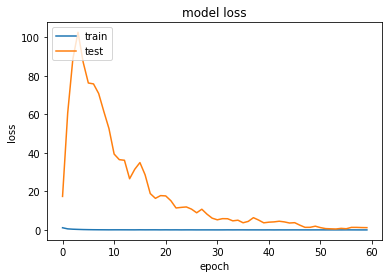

In [7]:
post.plot_history(SubBIA_history)

In [8]:
loss, acc = SubBIA.evaluate(X_valid, y_valid, verbose=0)
loss, acc

(1.361891746520996, 0.6858974099159241)

In [11]:
# remove the label from the dataframe
_df = df.drop('SUBTYPE', axis=1)

encpos = autoencoder_structure.get('encoder_position')

# compress the data to 150 dimensions 
enc150f = ae.extract_encoder(SubBIA, encpos.get(150))
red_ds_150 = pd.DataFrame(enc150f.predict(np.asarray(_df).astype('float32')))
red_ds_150.index = _df.index

# compress the data to 50 dimensions 
enc50f = ae.extract_encoder(SubBIA, encpos.get(50))
red_ds_50 = pd.DataFrame(enc50f.predict(np.asarray(_df).astype('float32')))
red_ds_50.index = _df.index

# compress the data to 25 dimensions 
enc25f = ae.extract_encoder(SubBIA, encpos.get(25))
red_ds_25 = pd.DataFrame(enc25f.predict(np.asarray(_df).astype('float32')))
red_ds_25.index = _df.index

csvs = microarray.get_data_sources()
source_filename = csvs[0].split('/')[1]

red_ds_150.to_csv(f'results/microarray/mainclass/biased_acc_{acc:.3f}_150f_reduced_{source_filename}')
red_ds_50.to_csv( f'results/microarray/mainclass/biased_acc_{acc:.3f}_50f_reduced_{source_filename}')
red_ds_25.to_csv( f'results/microarray/mainclass/biased_acc_{acc:.3f}_25f_reduced_{source_filename}')

## Predizione del sottotipo

In [12]:
use_biased_data = True

In [13]:
if (not use_biased_data):
    red_ds_150 = pd.read_csv('results/microarray/mainclass/loss_0.007_150f_reduced_data_mRNA_median_Zscores.txt', index_col=0)
    red_ds_50  = pd.read_csv('results/microarray/mainclass/loss_0.007_50f_reduced_data_mRNA_median_Zscores.txt',  index_col=0)
    red_ds_25  = pd.read_csv('results/microarray/mainclass/loss_0.007_25f_reduced_data_mRNA_median_Zscores.txt',  index_col=0) 
else:
    red_ds_150 = pd.read_csv('results/microarray/mainclass/biased_acc_0.686_150f_reduced_data_mRNA_median_Zscores.txt', index_col=0)
    red_ds_50  = pd.read_csv('results/microarray/mainclass/biased_acc_0.686_50f_reduced_data_mRNA_median_Zscores.txt',  index_col=0)
    red_ds_25  = pd.read_csv('results/microarray/mainclass/biased_acc_0.686_25f_reduced_data_mRNA_median_Zscores.txt',  index_col=0) 

Utilizziamo i dataset compressi a 150, 50 e 25 dimensioni per allenare un classificatore XGBoost a predire i principali sottotipi di tumore al seno.

In [14]:
df150 = pd.concat( [ red_ds_150, df['SUBTYPE'] ], axis=1, verify_integrity=True )
df50  = pd.concat( [ red_ds_50,  df['SUBTYPE'] ], axis=1, verify_integrity=True )
df25  = pd.concat( [ red_ds_25,  df['SUBTYPE'] ], axis=1, verify_integrity=True )

In [15]:
from xgboost import XGBClassifier

datasets = {
    '150': df150, 
    '50':  df50, 
    '25':  df25
}

classifiers = {
    '150': XGBClassifier(use_label_encoder=False), 
    '50':  XGBClassifier(use_label_encoder=False), 
    '25':  XGBClassifier(use_label_encoder=False)
} 

metrics = {
    '150': {}, 
    '50':  {}, 
    '25':  {}
}

Iteriamo su ogni dataset ed alleniamo il rispettivo classificatore XGBoost. Dopo la fase di allenamento validiamo il modello: calcoliamo l'accuratezza e, per ogni sottotipo di tumore, otteniamo la matrice binaria di confusione (1 vs all). Dalla matrice di confusione calcoliamo gli score: sensitivity, specificity, precision, NPV.

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, multilabel_confusion_matrix

for size in ['150', '50', '25']:
    
    ds = datasets.get(size)
    xg = classifiers.get(size)
    nx, ny = ds.shape
    
    # make a dataset partition 
    trainset, validset = util.multilabel_train_test_split(ds, 'SUBTYPE', .2)
    trainset, testset  = util.multilabel_train_test_split(trainset, 'SUBTYPE', .2)
    
    # make a label encoder 
    label_encoder = LabelEncoder()
    label_encoder.fit(trainset['SUBTYPE'].unique())
    
    # define some functions to extract X and y
    takex = lambda ds: ds.drop('SUBTYPE', axis=1)
    takey = lambda ds: label_encoder.transform(ds['SUBTYPE'])
    
    # extract X and y
    X_train, X_test, X_valid = takex(trainset), takex(testset), takex(validset)
    y_train, y_test, y_valid = takey(trainset), takey(testset), takey(validset)
    
    # train the model 
    xg.fit(X_train, y_train)
    
    # use the validation set to validate the model 
    y_pred = label_encoder.inverse_transform(xg.predict(X_valid))
    y_true = label_encoder.inverse_transform(y_valid)
    
    # get the metrics dictionary for the current size
    m = metrics.get(size)
    
    # calculate the accuracy
    m['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
    m['label_specific'] = {}
    
    # get the confusion matrices for each label
    # in the order specified in the following list
    
    subtypes = ['LumA', 'LumB', 'Basal', 'Her2']    
    cms = multilabel_confusion_matrix(y_true, y_pred, labels=subtypes)
    
    for index, subtype in enumerate(subtypes):
        
        label_metrics = {}
        label_metrics['confusion_matrix'] = cms[index]
        
        # extract the matrix informations 
        tn, fp, fn, tp = cms[index].ravel()
        
        # calculate metrics 
        label_metrics['sensitivity'] = round(tp / (tp + fn), 2)
        label_metrics['specificity'] = round(tn / (tn + fp), 2)
        label_metrics['precision']   = round(tp / (tp + fp), 2)
        label_metrics['npv']         = round(tn / (tn + fn), 2)
        
        # add the metrics to the label-specific property
        m['label_specific'][subtype] = label_metrics 
        

[14:13:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


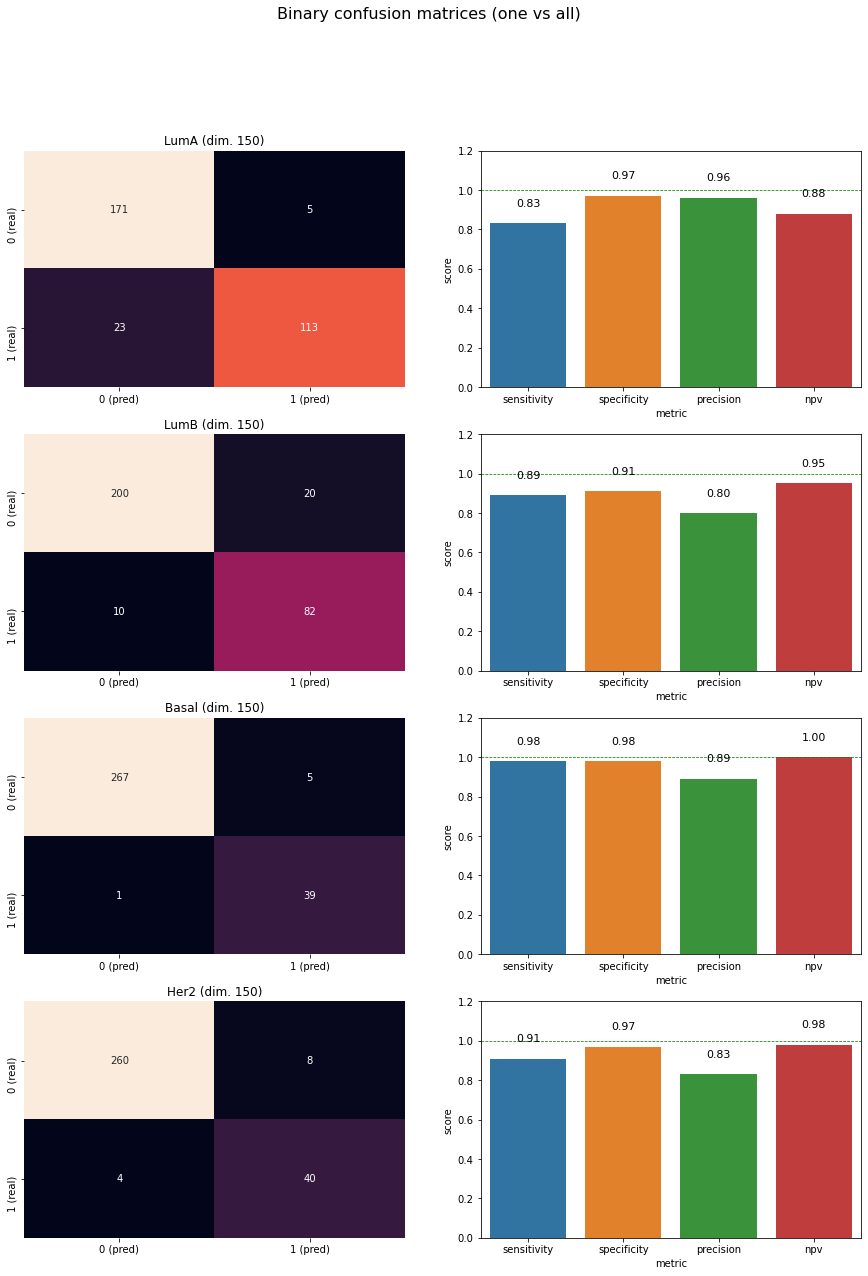

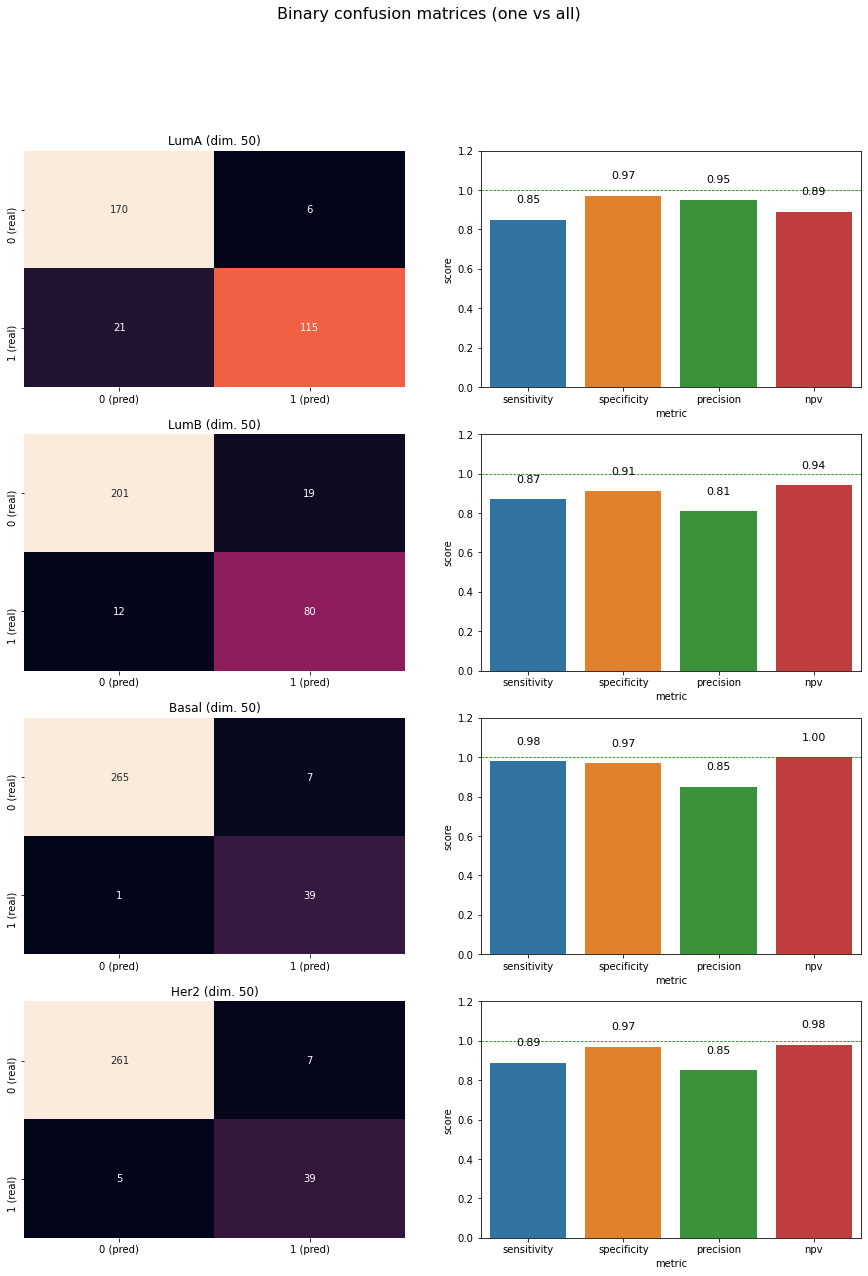

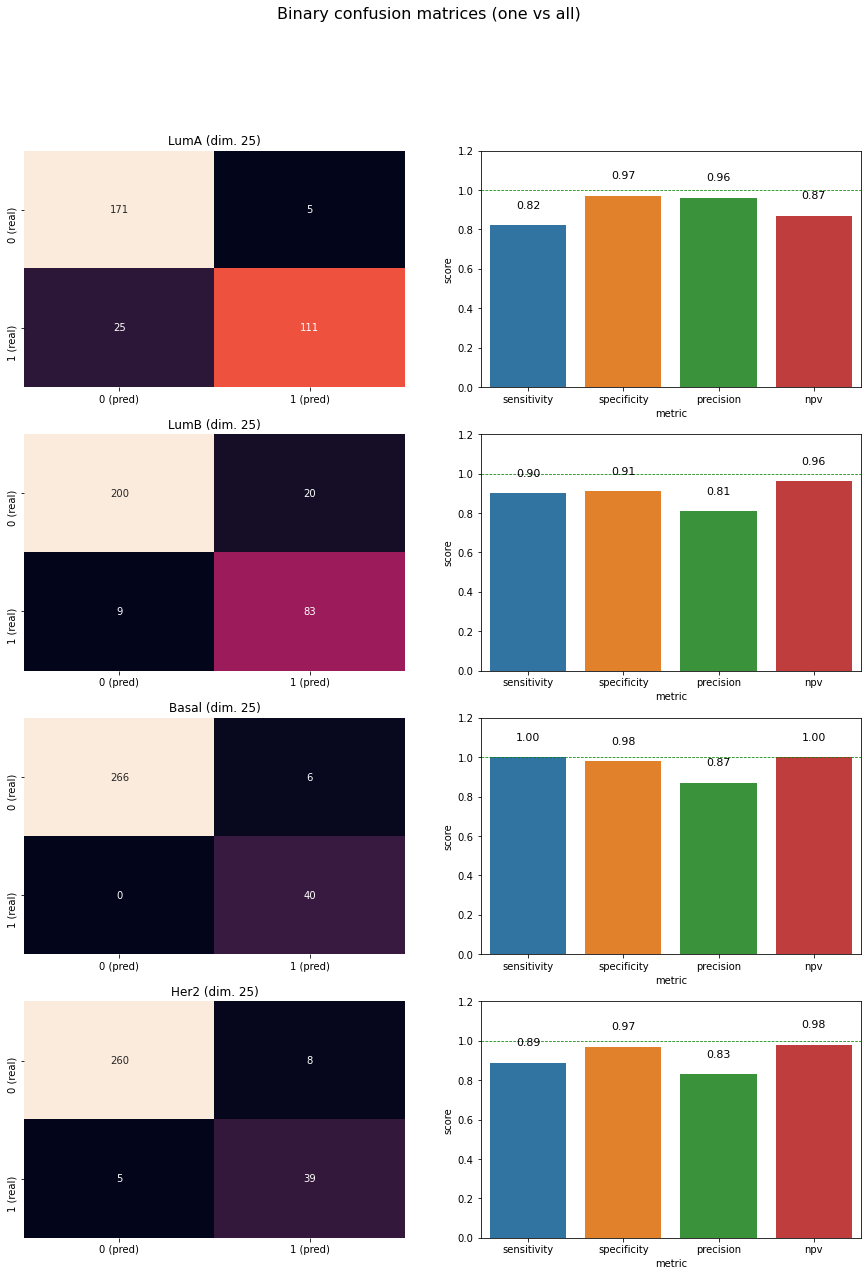

In [17]:
post.produce_binary_cm(metrics, 
                       dimensions=['150', '50', '25'], 
                       classes=subtypes, 
                       dataset_name='microarray-biased')